In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
from scipy.interpolate import griddata

In [3]:
from scipy.special import gammainc

In [4]:
connectivity_min, connectivity_max = 0,40
delay_min, delay_max = 0,5
# random_input_span = (1.2,2.8)
# random_input_span = (9.5,9.5)
random_input_span = (9.5,13.5)
total_time = 100
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[1]

model_folder_name = neuron_model+'_ensembles'
version = '_v2.0'
# version = '_v1.0'
# version = '_cluster_computed'

# Capture related ensembles

In [5]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [6]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [7]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [8]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        if delay > delay_max or delay < delay_min: continue #check if this connectivity is requested
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model in ['Rotational','Non_repulsive_rotational']: #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model in ['Rotational','Non_repulsive_rotational']:amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [9]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    table = table.dropna(axis=1, how='all')
    return table

def nested_dict_to_vectors(given_dict):
    coordinates = []
    for x in given_dict:
        for y in given_dict[x]:
            coordinates.append([x,y,given_dict[x][y]])
    return np.array(coordinates).T

def create_contour_phase_space(given_dict, title, plot_points = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    
    grid_x, grid_y = np.mgrid[g_arr[0]:g_arr[-1]:500j, delay_arr[0]:delay_arr[-1]:500j]
    
    points = nested_dict_to_vectors(given_dict)[0:2].T
    values = nested_dict_to_vectors(given_dict)[2]
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    extent = [min(g_arr),max(g_arr),min(delay_arr),max(delay_arr)]    
    
    filtered_grid = median_filter(grid_z.T, size = 20)
    
    ax.contourf(filtered_grid, extent = extent, cmap = 'inferno')
    C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)
    ax.clabel(C, inline=1, fontsize=10)
    
    if plot_points == True: ax.plot(points[:,0], points[:,1], 'w.', ms=1)
    
    ax.set_title('{} phase space'.format(title))
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('Delay (s)')
    plt.close()
    return fig, ax

In [10]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

In [11]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
g_arr = np.sort( sigma_table.columns )
delay_arr = np.sort( sigma_table.index )

In [12]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

# Sigma dataframe

In [13]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table

connectivity,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,...,9.8,9.9,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,,,,,,,,,,,,
0.50,0.033081,0.030939,0.031788,0.032441,0.030920,0.030801,0.030415,0.032596,0.030646,0.030135,...,0.777763,0.773706,0.730153,0.708896,0.686212,0.667948,0.653646,0.648869,0.634616,0.629751
0.75,0.034219,0.033951,0.032231,0.033605,0.032253,0.030439,0.031740,0.033967,0.034210,0.032807,...,0.816095,0.812149,0.742210,0.719575,0.708229,0.711543,0.696567,0.690836,0.666039,0.647079
1.00,0.032971,0.034138,0.033705,0.031972,0.034401,0.031932,0.033301,0.033279,0.031880,0.031851,...,0.782127,0.781262,0.750875,0.731642,0.721673,0.703154,0.679643,0.681948,0.665490,0.650260
1.25,0.033101,0.033772,0.032718,0.032855,0.031924,0.033140,0.032295,0.032569,0.030922,0.032043,...,0.782083,0.782611,0.757065,0.749127,0.732551,0.709336,0.696141,0.695850,0.674735,0.659503
1.50,0.033560,0.032472,0.033025,0.032584,0.032900,0.032197,0.032354,0.032185,0.032548,0.032703,...,0.785071,0.781923,0.754070,0.733812,0.724589,0.709321,0.694799,0.693972,0.664854,0.652429
1.75,0.031673,0.032908,0.031845,0.033608,0.032852,0.034221,0.032251,0.030851,0.030537,0.031219,...,NaN,NaN,0.764973,0.739338,0.732501,0.720170,0.706236,0.688966,0.679732,0.648228
2.00,0.032870,0.033857,0.032479,0.032330,0.033130,0.033829,0.033968,0.031177,0.030864,0.032549,...,0.792806,0.790548,0.748309,0.754422,0.731682,0.724964,0.702429,0.697170,0.675685,0.659474
2.25,0.035052,0.033608,0.031590,0.031758,0.033814,0.031381,0.033493,0.032259,0.031216,0.031588,...,NaN,NaN,0.762578,0.746674,0.710905,0.727356,0.718635,0.686597,0.677687,0.668899
0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.024761,0.024840,0.026714,0.030061,0.037632,0.042507,0.049978,0.081516


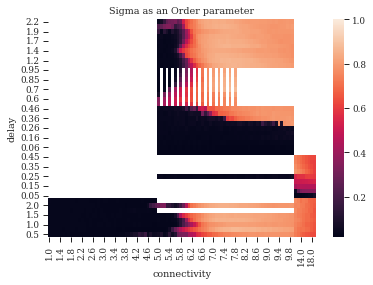

In [14]:
yticklabels = ['{:.2f}'.format(x) for x in sigma_table.index.to_list()]
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)

ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

# ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))

In [15]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

C:\Users\mohsen\AppData\Local\Temp\ipykernel_15652\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


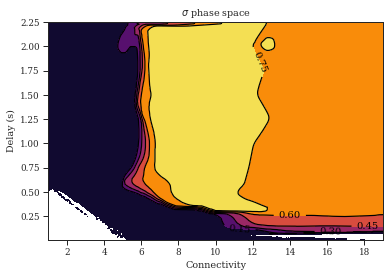

In [16]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp\ipykernel_15652\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


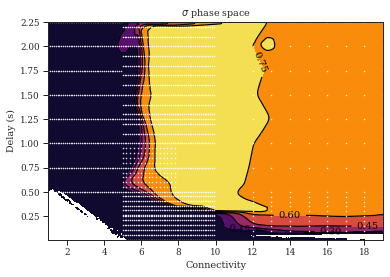

In [17]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = True)
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_points_plotted_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

## Transition point approx.

In [18]:
def first_trans_point_non_repulsive(alpha, g, d):
    return 2*np.pi/gammainc(2,alpha*d*1)

def second_trans_point_non_repulsive(alpha, g, d):
    D = alpha*d
    return 2*np.pi*gammainc(2,D) / (1 - np.e**(-D)*(D**3 + 3*D**2 + 6*D + 6)/6 )

In [32]:
def first_trans_point_rotational(alpha, g, d, random_input_span):
    D = alpha*d
    a = random_input_span[0]
    num = a + 1
    denom = gammainc(2,D)**2 * (a - 1) - 2 * gammainc(2,D)
    return 2*np.pi*np.sqrt( num / denom )

# def first_trans_point_rotational(a_min, alpha, g, d):
#     num = a_min - 1
#     ro = num / denom
#     return 2*np.pi/gammainc(2,alpha*d*1)

# def first_trans_point_rotational(alpha, g, d, random_input_span):
#     D = alpha*d
#     g /= 2*np.pi
#     rho = (-2*g*np.arcsinh(((2*g**2-29)*np.sqrt(4*g**2-4))/(58*g**2-58)) + \
#            2*g*np.arcsinh(((2*g**2-21)*np.sqrt(4*g**2-4))/(42*g**2-42)) - \
#            2*np.arcsinh(27/np.sqrt(4*g**2-4)) + \
#            2*np.arcsinh(19/np.sqrt(4*g**2-4)) + \
#            np.sqrt(4*g**2+725) - \
#            np.sqrt(4*g**2+357) + \
#            (2*np.log(21/2)-2*np.log(29/2))*g)/2
#     return 2*np.pi / ( gammainc(2,D) * rho )

### First approx of transition point 

C:\Users\mohsen\AppData\Local\Temp\ipykernel_15652\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


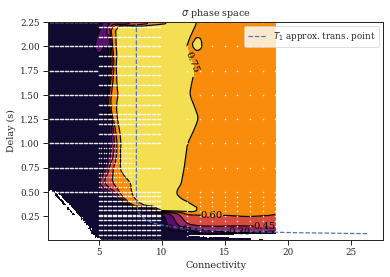

In [34]:

c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = True)

delay_mesh = np.arange(min(delay_arr)+0.06,max(delay_arr),0.01)
g_star_one = np.zeros_like(delay_mesh)
g_star_two = np.zeros_like(delay_mesh)

if neuron_model == current_models[2]:
    for i,d in enumerate(delay_mesh):
        g_star_one[i] = first_trans_point_non_repulsive(alpha, g, d)
        g_star_two[i] = second_trans_point_non_repulsive(alpha, g, d)

    c_ax.plot( g_star_one, delay_mesh, 'b--', label = r'$T_1$ approx. trans. point')
    c_ax.plot( g_star_two, delay_mesh, 'g--', label = r'$T_2$ approx. trans. point')
elif neuron_model == current_models[1]:
    for i,d in enumerate(delay_mesh):
        g_star_one[i] = first_trans_point_rotational(alpha, g, d, random_input_span)
#         g_star_one[i] = first_trans_point_non_repulsive(alpha, g, d)

    c_ax.plot( g_star_one, delay_mesh, 'b--', label = r'$T_1$ approx. trans. point')
    
c_ax.legend(loc='upper right')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_analytical_trans_points_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

# Amin Saman Parameter

C:\Users\mohsen\AppData\Local\Temp\ipykernel_15652\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


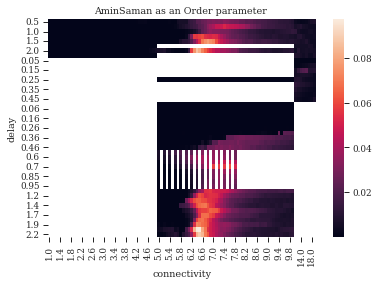

In [21]:
if neuron_model in ['Rotational','Non_repulsive_rotational']:
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))
    
    c_fig, c_ax = create_contour_phase_space(amin_saman_param_glossary_dict, 'AminSaman')
    c_fig.savefig(os.path.join(target_path, 'amin_saman_phase_space_contour.png'), dpi = 1000)

# Field period dataframe

In [22]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table

connectivity,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,...,9.8,9.9,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,,,,,,,,,,,,
0.50,2.777778,2.272727,1.960784,1.886792,1.851852,1.724138,1.562500,1.562500,1.449275,1.470588,...,1.470588,1.470588,1.562500,1.587302,1.639344,1.666667,1.724138,1.754386,1.818182,1.851852
0.75,3.225806,2.941176,2.702703,2.439024,2.439024,2.272727,2.272727,2.222222,2.127660,2.083333,...,2.083333,2.083333,2.173913,2.272727,2.380952,2.500000,2.564103,2.564103,2.631579,2.631579
1.00,3.846154,3.703704,3.333333,3.225806,3.030303,2.941176,2.777778,2.777778,2.702703,2.631579,...,2.597841,2.631579,2.857143,2.941176,3.030303,3.125000,3.125000,3.225806,3.333333,3.448276
1.25,5.000000,4.347826,4.000000,3.846154,3.703704,3.571429,3.448276,3.333333,3.333333,3.225806,...,3.225806,3.225806,3.571429,3.571429,3.703704,3.846154,4.000000,4.000000,4.166667,4.166667
1.50,5.555556,5.263158,4.761905,4.545455,4.347826,4.166667,4.166667,4.000000,3.846154,3.846154,...,3.846154,3.846154,4.166667,4.166667,4.347826,4.545455,4.545455,4.761905,4.761905,5.000000
1.75,6.666667,5.882353,5.555556,5.263158,5.000000,4.761905,4.761905,4.545455,4.545455,4.347826,...,NaN,NaN,4.761905,5.000000,5.000000,5.263158,5.263158,5.555556,5.555556,5.555556
2.00,7.142857,6.666667,6.250000,5.882353,5.882353,5.555556,5.263158,5.263158,5.000000,5.000000,...,5.000000,5.000000,5.555556,5.555556,5.882353,5.882353,5.882353,6.250000,6.250000,6.666667
2.25,8.333333,7.692308,7.142857,6.666667,6.250000,6.250000,5.882353,5.882353,5.555556,5.555556,...,NaN,NaN,5.882353,6.250000,6.250000,6.666667,6.666667,7.142857,7.142857,7.142857
0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.317460,0.284900,0.295858,0.289855,0.295858,0.280899,0.284091,0.281690


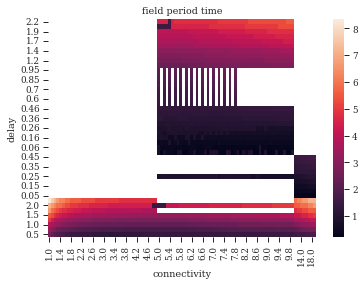

In [23]:
# ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period = sns.heatmap(field_period_table.abs(), annot=False)
ax_field_period.set_title('field period time')
ax_field_period.invert_yaxis()

In [24]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

C:\Users\mohsen\AppData\Local\Temp\ipykernel_15652\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


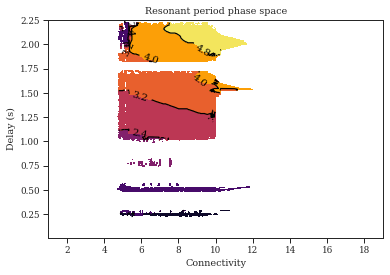

In [25]:
c_fig, c_ax = create_contour_phase_space(field_period_table.abs().to_dict(), 'Resonant period')
c_fig.savefig(os.path.join(target_path, 'field_period_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [26]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table.head()

connectivity,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,...,9.8,9.9,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,,,,,,,,,,,,
0.50,86.322966,84.730504,83.390701,82.783161,81.974783,81.518045,81.688076,81.920051,81.793177,81.651002,...,5179.369582,4903.205640,4526.532739,3919.500930,3967.134113,4110.361968,3088.473870,3867.745542,3597.336226,2871.910761
0.75,120.902193,119.860112,118.499057,117.777880,116.854866,116.336566,116.214283,115.821708,116.206911,116.532519,...,5108.624167,5034.903759,3872.890116,3646.470799,4084.292782,3884.438300,3714.118678,3672.758620,3706.674785,2949.981293
1.00,156.412365,154.549135,153.258520,151.985485,150.767842,150.796388,150.237687,149.999956,151.312261,151.125172,...,3509.977322,4035.606006,4849.155990,4039.587924,4508.882132,3907.905089,3085.006524,3839.411743,3577.817268,3771.590026
1.25,191.301971,189.285026,187.652788,186.888919,185.499140,184.801815,184.648154,185.075663,185.184656,185.935949,...,3501.504767,4357.278474,3399.948899,4616.726003,3990.913715,3989.970201,3687.957479,3829.685584,3153.940735,3762.539461
1.50,225.158742,224.111942,222.502544,220.718057,219.671953,219.061535,218.735650,219.120711,220.081106,220.364110,...,5132.443046,5211.820588,3921.594553,3604.572104,3695.757219,4257.829433,3259.038042,3867.201250,2644.859486,3760.338254


C:\Users\mohsen\AppData\Local\Temp\ipykernel_15652\2211277142.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


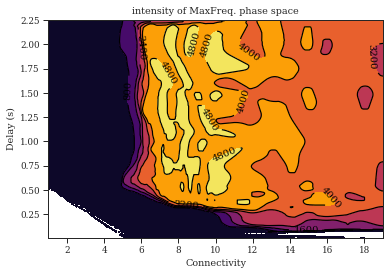

In [27]:
c_fig, c_ax = create_contour_phase_space(field_max_intensity_mod_glossary_dict, 'intensity of MaxFreq.')
c_fig.savefig(os.path.join(target_path, 'max_intensity_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [28]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# d_arr = max_intensity_table.index
# g_arr = max_intensity_table.columns
# bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

# dd_arr = d_arr[1] - d_arr[0]
# dg_arr = g_arr[1] - g_arr[0]

# dmax_intensity = max_intensity_table.to_numpy().flatten()

# cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
# period_arr = field_period_table.to_numpy().flatten()
# max_height = np.max(period_arr)   # get range of colorbars so we can normalize
# min_height = np.min(period_arr)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap( np.log( k ) ) for k in period_arr] 


# fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
# # ax = fig.add_subplot(111, projection='3d')
# # ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)